# Compte rendu de Dardare Clément et Mendiharat Titouan

In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wavfile
from scipy.signal import hamming
from scipy.spatial.distance import cdist

import IPython.display as ipd
from mdct.fast import mdct, imdct
from scipy.io.wavfile import write

plt.rcParams['figure.figsize'] = (12,8)

In [3]:
# useful functions

def plot_sound(data, rate, title=None):
    if data.ndim == 1:
        data = data[:,np.newaxis]
    times = np.arange(data.shape[0])/rate
    plt.figure(figsize=(30,6))
    for channel in data.T:
        plt.fill_between(times, channel)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.xlim(times[0], times[-1])
    if title:
        plt.title(title)
    plt.show()
    
def play_sound(data, rate):
    return ipd.Audio(data.T, rate=rate)

## Question 1


T = 220501, M = 2


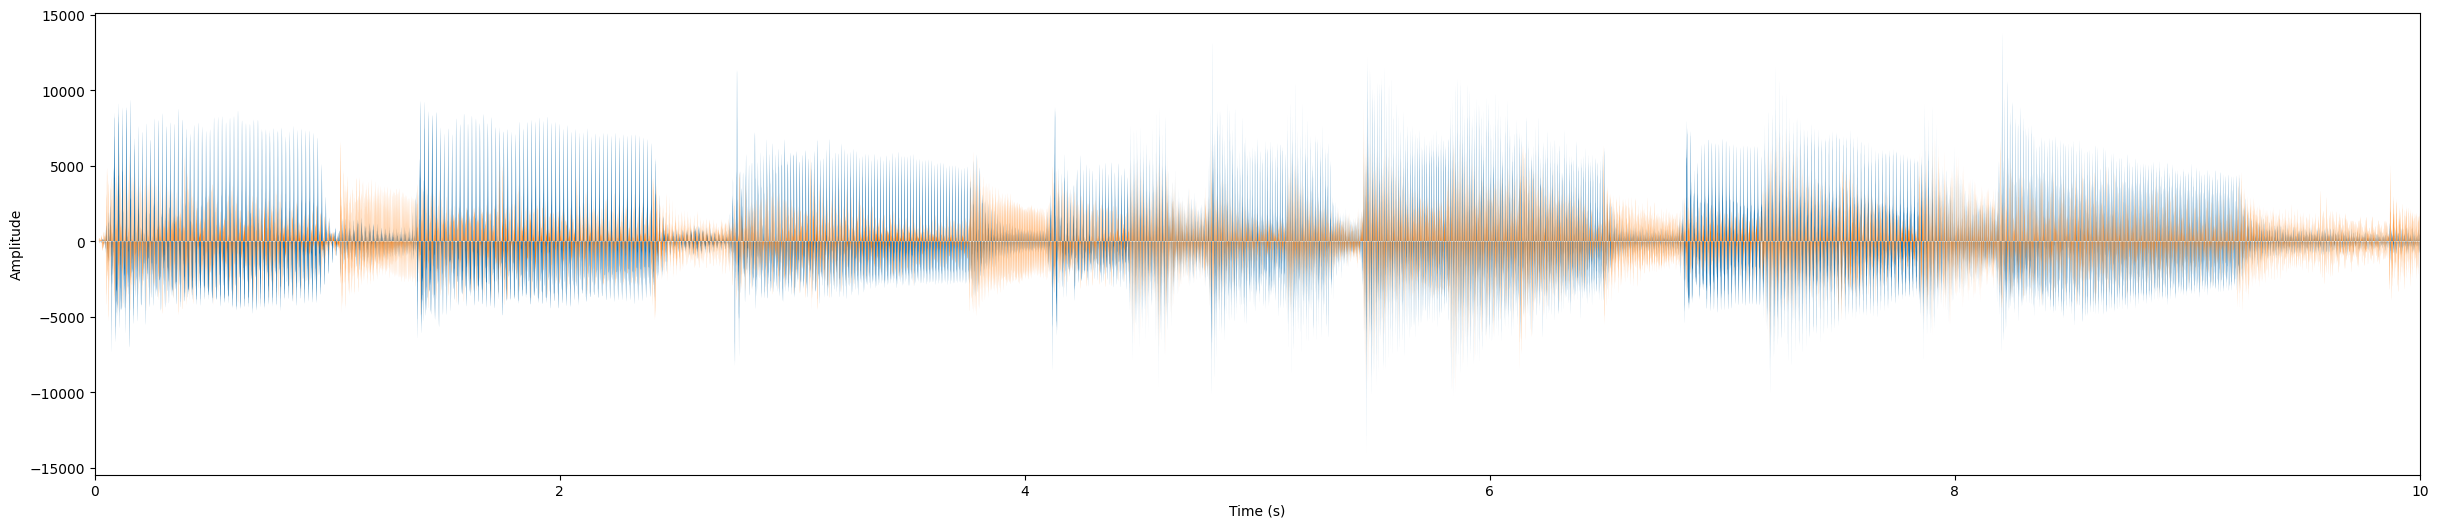

In [4]:
fname = 'mix.wav'

rate, x = wavfile.read(fname)
print('T = {:d}, M = {:d}'.format(*x.shape))
plot_sound(x, rate)
play_sound(x, rate)

We hear 3 instruments that are from left to right : bass, guitar and piano on both sides.

## Question 2

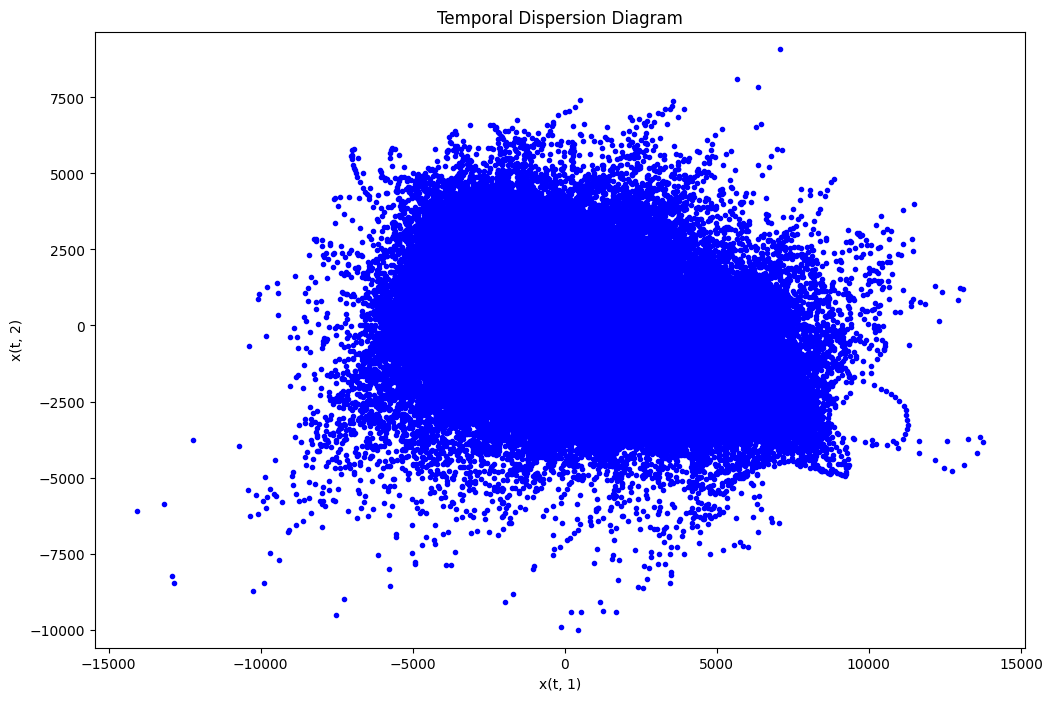

In [5]:
plt.plot(x[:, 0], x[:, 1], 'b.')
plt.xlabel('x(t, 1)')
plt.ylabel('x(t, 2)')
plt.axis('equal')
plt.title('Temporal Dispersion Diagram')
plt.show()

No, we cannot identify the direction of the sources.

## Question 3

In [6]:
write('new_mix.wav', rate, np.array(x, dtype=np.int16)) # to write a new wave file

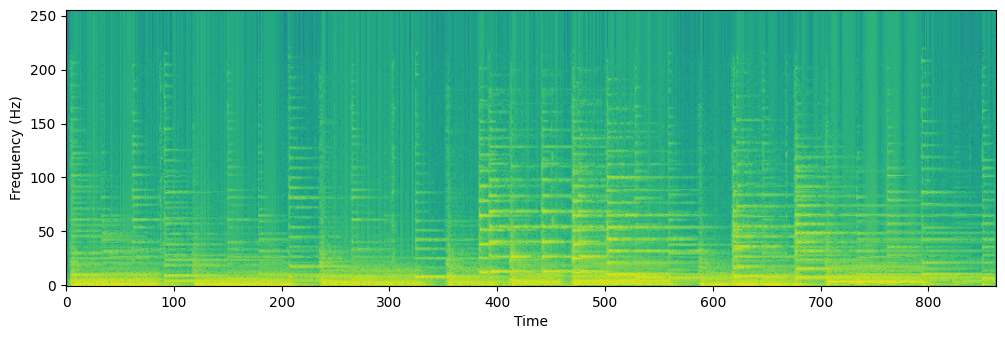

In [7]:
X = mdct(x, window=hamming, framelength=512)
Z = X.view(dtype=np.complex128)[...,0]

X_norm = np.abs(Z)**2

plt.imshow(np.log(X_norm+1e-10), origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.show()

## Question 4

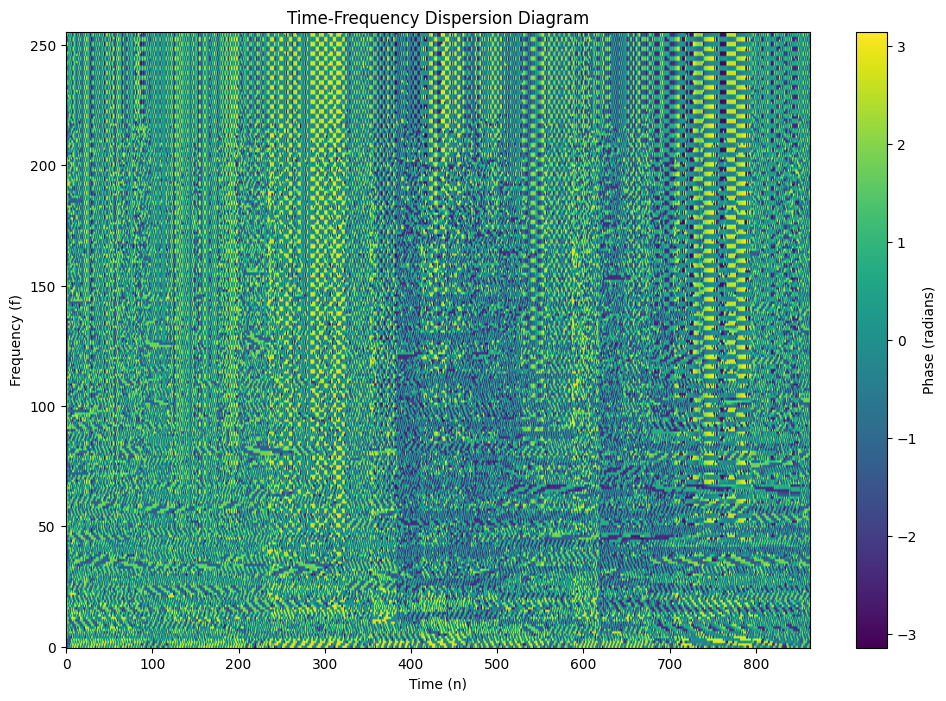

In [8]:
plt.imshow(np.angle(Z), aspect='auto', origin='lower')
plt.xlabel('Time (n)')
plt.ylabel('Frequency (f)')
plt.title('Time-Frequency Dispersion Diagram')
plt.colorbar(label='Phase (radians)')
plt.show()

## Question 5

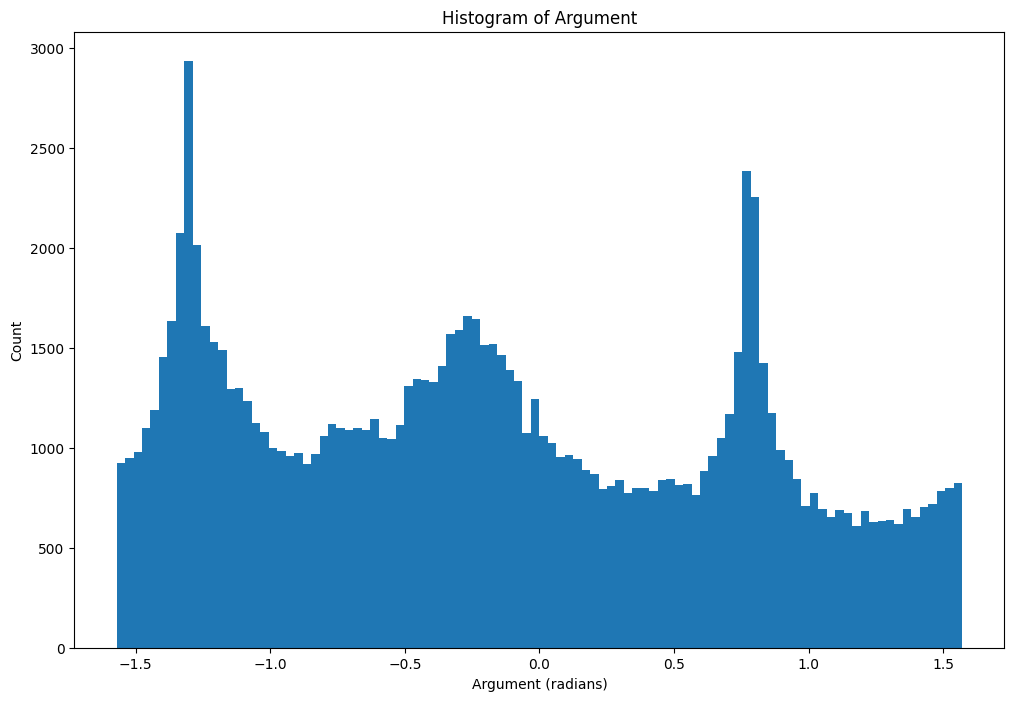

In [11]:
# Compute the arguments of Z(f, n) modulo pi
arguments = np.arctan2(np.imag(Z), np.real(Z))

# Plot the histogram
num_bins = 100  # Number of histogram bins (adjust as needed)
plt.hist(arguments.flatten(), bins=num_bins, range=(-np.pi / 2, np.pi / 2))
plt.xlabel('Argument (radians)')
plt.ylabel('Count')
plt.title('Histogram of Argument')
plt.show()

In [12]:
from scipy.signal import find_peaks

# Estimations of the theta(k)

arguments = np.arctan2(np.imag(Z), np.real(Z))
hist, bin_edges = np.histogram(arguments.flatten(), bins=num_bins, range=(-np.pi / 2, np.pi / 2))
peaks, _ = find_peaks(hist)
angle_bins = (bin_edges[:-1] + bin_edges[1:]) / 2
peak_angles = angle_bins[peaks]

theta = peak_angles

Here follows the list of peaks.

In [14]:
print(theta)

[-1.30376095 -1.11526539 -0.89535391 -0.7696902  -0.67544242 -0.61261057
 -0.45553093 -0.26703538 -0.1727876  -0.01570796  0.10995574  0.2984513
  0.36128316  0.48694686  0.54977871  0.7696902   1.02101761  1.11526539
  1.20951317  1.30376095  1.3665928 ]


Graphically, the most notable ones are -1,3 and 0,8 since they are the biggest.

## Question 6

In [13]:
F = 256

arg_Z_mod_pi = np.angle(Z) % np.pi

B = np.zeros((F, X.shape[1], len(theta)))

# Estimate active source at each time-frequency bin
for f in range(F):
    for n in range(X.shape[1]):
        deviation = []
        for k in range(len(theta)) :
            deviation.append(np.abs(np.exp(1j * theta[k]) - np.exp(1j * arg_Z_mod_pi[f, n])))
        
        deviation = np.array(deviation)
        closest_source = np.argmin(deviation)
        B[f, n, closest_source] = 1

## Question 7

In [11]:
print(X.shape)

(256, 863, 2)


In [29]:
T, M, _ = X.shape
K = len(theta)
y = np.zeros((T, M, K))

for k in range(len(theta)):
    Y = B[..., k] * Z
    y[..., k] = imdct(Y)

ValueError: operands could not be broadcast together with shapes (512,) (1024,) 

## Question 9

In [ ]:
S = np.zeros_like(X)
s = np.zeros((T, K))

for k in range(K):
    S[..., k] = B[..., k] * X[..., 0] * np.cos(theta[k]) + B[..., k] * X[..., 1] * np.sin(theta[k])

for k in range(K):
    s[:, k] = imdct(S[..., k])

In [ ]:
for k in range(K):
    print(f"Source {k+1}")
    play_sound(s[:, k], rate)

## Question 10

In [ ]:
new_theta = [theta[1], theta[0]]  # Permute the directions of the sources
new_x = np.zeros((T, M))
new_S = np.zeros_like(S)

for k in range(K):
    new_S[..., k] = B[..., k] * X[..., 0] * np.cos(new_theta[k]) + B[..., k] * X[..., 1] * np.sin(new_theta[k])
    


for m in range(M):
    for k in range(K):
        new_x[:, m] += imdct(new_S[..., k])[:, m]

print("Resynthesized Mixture")
play_sound(new_x, rate)

## Feedback

When it comes to this practical work, Dardare and I were pretty hyped up because we enjoyed the lesson and the topic was very interesting as this is one of the uses of AI that we hear a lot about and we wanted to know more about it. Just like the previous practical work, we first started by trying to understand what was going on before doing any sort of coding. Last time, we gained a lot of time by doing so and wanted to do it over. This helped us be more focused, understand better and be able to better grasp the concept of what we were doing.

As we started coding, it was going pretty smoothly until the question 7. Indeed, up until now (Friday 11:40) we have not been able to debug it. We broke our heads on it and tried asking friends how they did but unfortunately, we didn’t manage to complete this question. This is very frustrating as we didn’t get to see the end of the practical session, the goal we had been working towards. I guess this is also part of the learning process but remains annoying. I look forward to seeing a correction or something because I really want to discover more about this topic and understand my mistakes. We tried implementing the rest of the questions be it was pretty useless given that our question 7 didn’t run and there ws no way for the following ones to work without it.
